# 桥梁温度监测数据（间隔5分钟）

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import metrics
import numpy as np
import math
from pylab import mpl
# 设置显示中文字体
mpl.rcParams['font.sans-serif'] = ['SimHei']
# 设置正常显示符号
mpl.rcParams['axes.unicode_minus'] = False
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

# 数据的差分转换
def difference(data_set, interval=1):
    diff = list()
    for i in range(interval, len(data_set)):
        value = data_set[i] - data_set[i - interval]
        diff.append(value)
    return pd.Series(diff)


# 对预测的数据进行逆差分转换
def invert_difference(history, yhat, interval):#皇屿的是interval=1
    return yhat + history[-interval]


# 将数据转换为监督学习集，移位后产生的NaN值补0
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


# 将数据缩放到[-1,1]之间
def scale(train, test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler = MinMaxScaler(feature_range=(-1, 1))
    # 使用数据来训练缩放器
    scaler = scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


# 将预测值进行逆缩放，使用之前训练好的缩放器，x为一维数组，y为实数
def invert_scale(scaler, X, y):
    # 将X,y转换为一个list列表
    new_row = [x for x in X] + [y]
    # 将列表转换为数组
    array = np.array(new_row)
    # 将数组重构成一个形状为[1,2]的二维数组->[[10,12]]
    array = array.reshape(1, len(array))
    # 逆缩放输入的形状为[1,2]，输出形状也是如此
    invert = scaler.inverse_transform(array)
    # 只需要返回y值即可
    return invert[0, -1]


# 构建一个LSTM模型
def fit_lstm(train, batch_size, nb_epoch, neurons):
    # 将数据对中的x和y分开
    X, y = train[:, 0:-1], train[:, -1]
    # 将2D数据拼接成3D数据，形状为[N*1*1]
    X = X.reshape(X.shape[0], 1, X.shape[1])

    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        # shuffle是不混淆数据顺序
        his = model.fit(X, y, batch_size=batch_size, verbose=1, shuffle=False)
        # 每训练完一次就重置一次网络状态，网络状态与网络权重不同
        model.reset_states()
    return model


# 开始单步预测
def forecast_lstm(model, batch_size, X):
    # 将形状为[1:]的，包含一个元素的一维数组X，转换形状为[1,1,1]的3D张量
    X = X.reshape(1, 1, len(X))
    # 输出形状为1行一列的二维数组yhat
    yhat = model.predict(X, batch_size=batch_size)
    # 将yhat中的结果返回
    return yhat[0, 0]

In [8]:
data = pd.read_excel(r'../datasets/202005数据.xls',sheet_name='温度监测')

In [9]:
data.head()

,Unnamed: 0,A1,A2,B1,B2,C1,C2,D1,D2
0,2020-05-01 00:00:00,26.007500,25.981667,26.065833,25.994167,25.925833,25.982500,26.142500,25.964167
1,2020-05-01 00:05:00,26.080000,26.004286,25.951429,25.934286,26.039286,25.998571,26.140000,25.953571
2,2020-05-01 00:10:00,25.994167,26.065833,25.949167,26.070833,25.900833,25.985000,25.985833,26.120000
3,2020-05-01 00:15:00,26.675714,26.689286,26.732143,26.732143,26.687857,26.702143,26.657857,26.688571
4,2020-05-01 00:20:00,26.280714,26.278571,26.310000,26.290000,26.269286,26.311429,26.300000,26.345714


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5876 entries, 0 to 5875
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5876 non-null   object 
 1   A1          5876 non-null   float64
 2   A2          5876 non-null   float64
 3   B1          5876 non-null   float64
 4   B2          5876 non-null   float64
 5   C1          5876 non-null   float64
 6   C2          5876 non-null   float64
 7   D1          5876 non-null   float64
 8   D2          5876 non-null   float64
dtypes: float64(8), object(1)
memory usage: 413.3+ KB


In [27]:
temperature_data_short = data.iloc[:5877,6]
temperature_data_short.head()

0    25.982500
1    25.998571
2    25.985000
3    26.702143
4    26.311429
Name: C2, dtype: float64

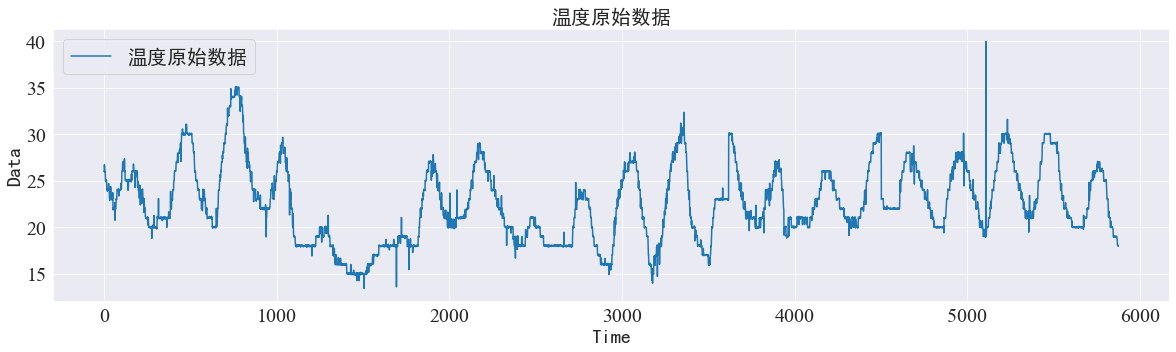

In [28]:
# 设置显示中文字体
mpl.rcParams['font.sans-serif'] = ['SimHei']
# 设置正常显示符号
mpl.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,5))
plt.plot(temperature_data_short, label='温度原始数据')
plt.legend(loc='upper left', fontsize=50,prop={"size":20,"weight":"black"})
plt.title('温度原始数据',fontdict={'weight':'normal','size': 20}) #改变图标题字体
plt.xlabel('Time', fontdict={'weight': 'normal', 'size': 20})#改变坐标轴标题字体
plt.ylabel('Data', fontdict={'weight': 'normal', 'size': 20})#改变坐标轴标题字体
plt.xticks(fontproperties = 'Times New Roman', size = 20)
plt.yticks(fontproperties = 'Times New Roman', size = 20)
plt.show()

In [30]:
# 将原数据转换为二维数组形式
raw_value=np.expand_dims(temperature_data_short,axis=1)
print(raw_value.shape)
# print(raw_value)
# 将数据进行差分转换，例如[[4.6838],[4.6882],[4.7048]]转换为[[4.6882-4.6838],[4.7048-4.6882]]
diff_value = difference(raw_value, 1)
# 将序列形式的数据转换为监督学习集形式，例如[[10],[11],[12],[13]]
# 在此将其转换为监督学习集形式：[[0,10],[10,11],[11,12],[12,13]]，
# 即前一个数作为输入，后一个数作为对应的输出
# print(diff_value.shape)
# print(diff_value)
supervised = timeseries_to_supervised(diff_value, 1)
supervised_value = supervised.values
# 将数据集分割为训练集和测试集，设置后testNum个数据为测试集
testNum = 497
train, test = supervised_value[:-testNum], supervised_value[-testNum:]
print(train.shape)
print(test.shape)
# print(test)
# 将训练集和测试集都缩放到[-1,1]之间
scaler, train_scaled, test_scaled = scale(train, test)
print(train_scaled.shape)
print(test_scaled.shape)
# print(test_scaled)

(5876, 1)
(5378, 2)
(497, 2)
(5378, 2)
(497, 2)


In [31]:
train2 = train_scaled[:,0].reshape(-1,1)
y_train2 = train_scaled[:,1]
test2 = test_scaled[:,0].reshape(-1,1)
y_test2 = test_scaled[:,1]
print(train2.shape)
print(y_train2.shape)
print(test2.shape)
print(y_test2.shape)

(5378, 1)
(5378,)
(497, 1)
(497,)


## 机器学习中的模型

In [32]:
#建立模型
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
#标准化
#有些时候，数据集中存在离群点，用Z-Score进行标准化，但是结果不理想，因为离群点在标准化后丧失了利群#特性。RobustScaler针对离群点做标准化处理，该方法对数据中心化的数据的缩放健壮性有更强的参数控制能#力。
# scaler = RobustScaler()
# train = scaler.fit_transform(train)
# test = scaler.transform(test)

#评价函数
#先定义一个评价函数。我们采用10折交叉验证。与比赛的评价标准一致，我们用Root-Mean-Squared-Error (RMSE)来为每个模型打分。
#Validation function
n_folds = 10
#定义一个评价函数：
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train2)
    rmse= np.sqrt(-cross_val_score(model, train2, y_train2, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [33]:
#基本模型
lasso = Lasso(alpha=0.0005, random_state=1)
#弹性网络
ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
#核岭回归
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
#梯度提升回归
GBoost = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5)
#XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.05,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.8, n_estimators=1000,
                             reg_alpha=0.5, reg_lambda=0.8,
                             subsample=0.5,
                             random_state =7, nthread = -1)
#LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=1000)
#看看他们的表现
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} \n".format(score.mean()))#std标准差
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} \n".format(score.mean()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} \n".format(score.mean()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} \n".format(score.mean()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} \n".format(score.mean()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f}\n" .format(score.mean()))


Lasso score: 0.0254 

ElasticNet score: 0.0254 

Kernel Ridge score: 0.0247 

Gradient Boosting score: 0.0251 

Xgboost score: 0.0252 

LGBM score: 0.0250



In [34]:
#集成学习往往能进一步提高模型的准确性，Stacking是其中一种效果颇好的方法，简单来说就是学习各个基本模型的预测值来预测最终的结果。详细步骤可参考：https://www.jianshu.com/p/59313f43916f
#这里我们用ENet、KRR和GBoost作为第一层学习器，用Lasso作为第二层学习器：
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
 
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
 
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                instance.fit(X[train_index], y[train_index])
                self.base_models_[i].append(instance)
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
 
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
 
    # Do the predictions of all base models on the test data and use the averaged predictions as
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)
#Stacking的交叉验证评分：
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

In [35]:
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ".format(score.mean()))

Stacking Averaged models score: 0.0254 


### KernelRidge

In [36]:
KRR.fit(train2, y_train2)

KernelRidge(alpha=0.6, coef0=2.5, degree=2, kernel='polynomial')

In [37]:
# 遍历测试集，对数据进行单步预测
predictions = list()
for i in range(len(test2)):
    X = test2[i]
    X2=X.reshape(1,-1)
    # 将训练好的模型、测试数据传入预测函数中
    yhat = KRR.predict(X2)
    yhat = yhat[0]
    # 将预测值进行逆缩放
    yhat = invert_scale(scaler, X, yhat)
    # 对预测的y值进行逆差分
    yhat = invert_difference(raw_value, yhat, len(test_scaled) + 1 - i)
    # 存储正在预测的y值
    predictions.append(yhat)

In [38]:
predictions

[array([21.20654964]),
 array([21.02258269]),
 array([21.0215817]),
 array([21.02668121]),
 array([20.99831029]),
 array([21.10832657]),
 array([21.68282493]),
 array([22.01753059]),
 array([22.00645417]),
 array([22.10648657]),
 array([22.56433791]),
 array([22.72379548]),
 array([22.23667291]),
 array([22.00942698]),
 array([21.99343344]),
 array([21.95437618]),
 array([21.94525413]),
 array([22.18826104]),
 array([22.73428967]),
 array([22.96391776]),
 array([22.93794169]),
 array([22.9899503]),
 array([23.05069418]),
 array([22.71168403]),
 array([22.85915455]),
 array([22.9784094]),
 array([23.01201093]),
 array([23.02251613]),
 array([22.99930497]),
 array([23.01704903]),
 array([23.22744696]),
 array([24.0082242]),
 array([24.76134191]),
 array([24.98390224]),
 array([24.98132943]),
 array([25.01644031]),
 array([25.04202257]),
 array([24.99637761]),
 array([24.99966233]),
 array([25.04035698]),
 array([25.03966211]),
 array([25.04247343]),
 array([25.20075519]),
 array([25.9982

In [39]:
# 计算误差的方差与平均相对误差绝对值
mse = mean_squared_error(raw_value[-testNum:], predictions)
rmse = np.sqrt(mse)
# mape = mean_absolute_percentage_error(raw_value[-testNum:], predictions)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
mape = mape(raw_value[-testNum:], predictions)
print("Test MSE:%.7f" % mse)
print("Test RMSE:%.7f" % rmse)
print("Test MAPE:%.7f" % mape)

Test MSE:0.1056009
Test RMSE:0.3249629
Test MAPE:0.7576759


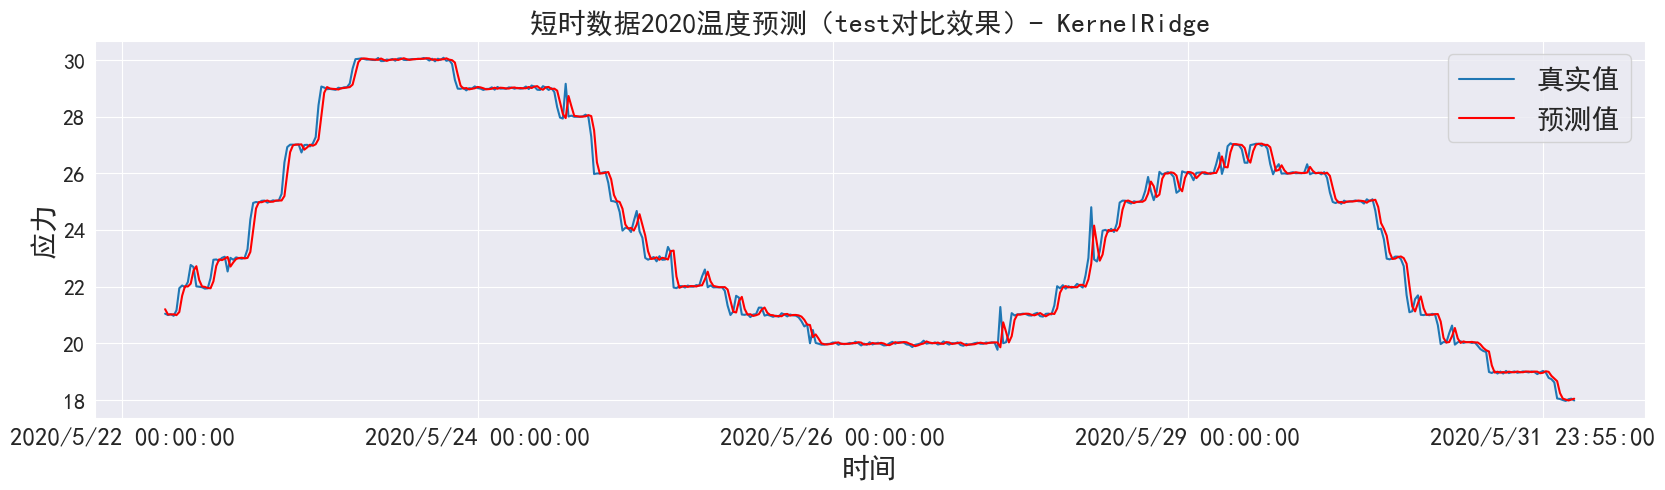

In [42]:
plt.figure(figsize=(20,5), dpi=100)
plt.title("短时数据2020温度预测（test对比效果）- KernelRidge",fontsize=20)
plt.plot(raw_value[-testNum:])
plt.plot(predictions,color="red")
plt.xlabel("时间",fontsize=20)
plt.ylabel("应力",fontsize=20)
labels=['2020/5/22 00:00:00','2020/5/24 00:00:00','2020/5/26 00:00:00','2020/5/29 00:00:00','2020/5/31 23:55:00']
plt.xticks(range(-15,610,125),labels=labels,fontsize=18)
plt.yticks(fontsize=16)
plt.legend(['真实值', '预测值'],fontsize=20)
plt.show()

### stacked_averaged_models

In [43]:
stacked_averaged_models.fit(train2, y_train2)

StackingAveragedModels(base_models=(ElasticNet(alpha=0.0005, l1_ratio=0.9,
                                               random_state=3),
                                    GradientBoostingRegressor(learning_rate=0.05,
                                                              loss='huber',
                                                              max_depth=4,
                                                              max_features='sqrt',
                                                              min_samples_leaf=15,
                                                              min_samples_split=10,
                                                              n_estimators=1000,
                                                              random_state=5),
                                    KernelRidge(alpha=0.6, coef0=2.5, degree=2,
                                                kernel='polynomial')),
                       meta_model=Lasso(alpha=0.0005, random_state=

In [44]:
# 遍历测试集，对数据进行单步预测
predictions = list()
for i in range(len(test2)):
    X = test2[i]
    X2=X.reshape(1,-1)
    # 将训练好的模型、测试数据传入预测函数中
    yhat = stacked_averaged_models.predict(X2)
    yhat = yhat[0]
    # 将预测值进行逆缩放
    yhat = invert_scale(scaler, X, yhat)
    # 对预测的y值进行逆差分
    yhat = invert_difference(raw_value, yhat, len(test_scaled) + 1 - i)
    # 存储正在预测的y值
    predictions.append(yhat)

In [45]:
# 计算误差的方差与平均相对误差绝对值
mse = mean_squared_error(raw_value[-testNum:], predictions)
rmse = np.sqrt(mse)
# mape = mean_absolute_percentage_error(raw_value[-testNum:], predictions)
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
mape = mape(raw_value[-testNum:], predictions)
print("Test MSE:%.7f" % mse)
print("Test RMSE:%.7f" % rmse)
print("Test MAPE:%.7f" % mape)

Test MSE:0.0932517
Test RMSE:0.3053715
Test MAPE:0.6797090


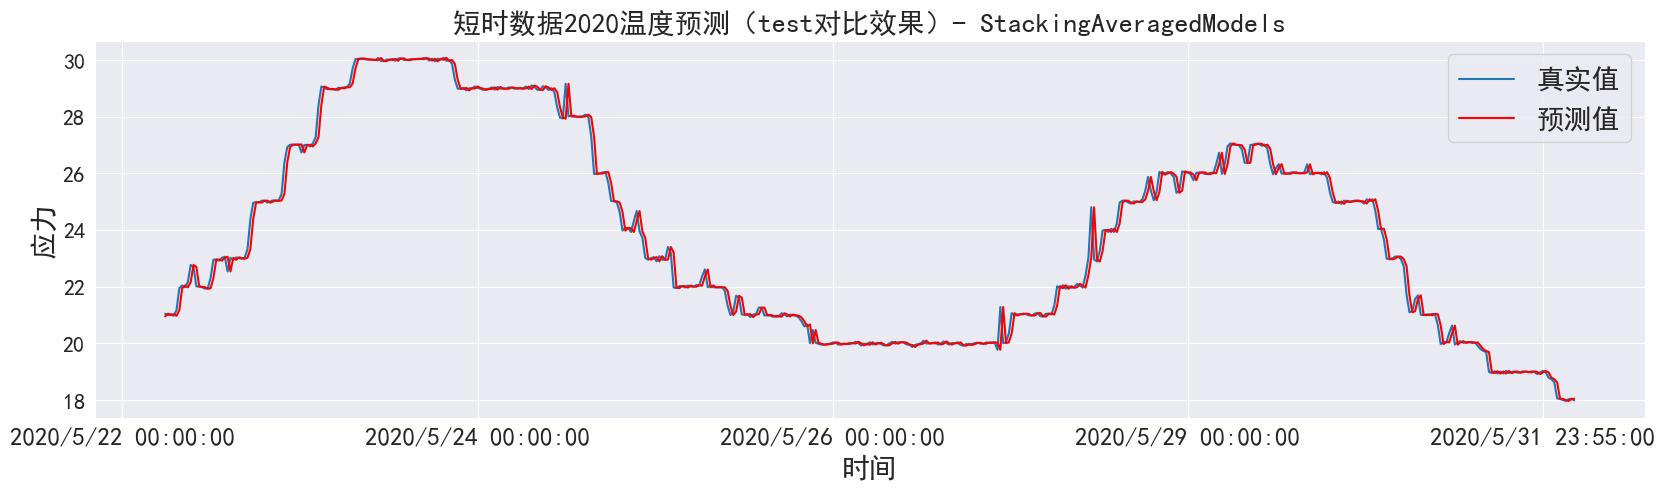

In [46]:
plt.figure(figsize=(20,5), dpi=100)
plt.title("短时数据2020温度预测（test对比效果）- StackingAveragedModels",fontsize=20)
plt.plot(raw_value[-testNum:])
plt.plot(predictions,color="red")
plt.xlabel("时间",fontsize=20)
plt.ylabel("应力",fontsize=20)
labels=['2020/5/22 00:00:00','2020/5/24 00:00:00','2020/5/26 00:00:00','2020/5/29 00:00:00','2020/5/31 23:55:00']
plt.xticks(range(-15,610,125),labels=labels,fontsize=18)
plt.yticks(fontsize=16)
plt.legend(['真实值', '预测值'],fontsize=20)
plt.show()

## ARIMA

In [47]:
#定义train集和test集数据
train3 = temperature_data_short.iloc[:-testNum]
test3 = temperature_data_short.iloc[-testNum:]
print(train3.shape)
print(test3.shape)

(5379,)
(497,)


In [48]:
# 定义ARMA模型的 data 数据
data_arima = pd.concat([train3, test3], ignore_index=True)
data_arima.shape

(5876,)

In [49]:
# 稳定性判断
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 7):
    
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    # plot rolling statistics:
    plt.figure(figsize=(15, 5))
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, label = 'Rolling Mean')
    plt.plot(rolstd, label= 'Rolling Standard Deviation')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid()
    
    # Dickey-Fuller test:
    
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    # dftest的输出前一项依次为检测值，p值，滞后数，使用的观测数，各个置信度下的临界值
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','P-Value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical value (%s)' %key] = value
    
    print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -6.131085e+00
P-Value                        8.398808e-08
Lags Used                      2.500000e+01
Number of Observations Used    5.850000e+03
Critical value (1%)           -3.431468e+00
Critical value (5%)           -2.862034e+00
Critical value (10%)          -2.567033e+00
dtype: float64


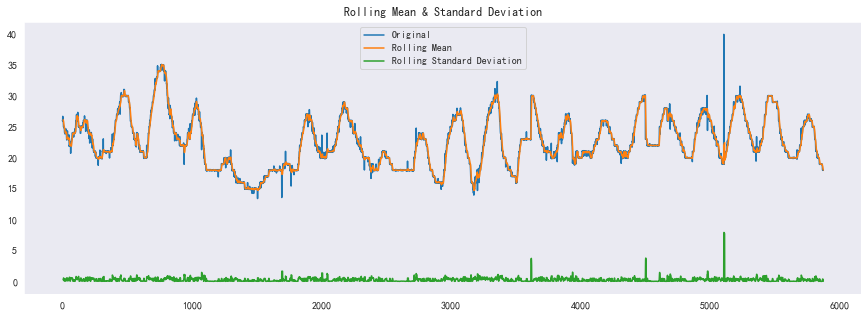

In [50]:
arx = pd.DataFrame(pd.to_numeric(data_arima))

test_stationarity(arx)

(-10.077524589675054, 1.2126940636785863e-17, 24, 5850, {'1%': -3.4314683199526126, '5%': -2.862034192295842, '10%': -2.567033056439477}, 9276.90686248217)
(-21.60573869033463, 0.0, 31, 5842, {'1%': -3.431469852046985, '5%': -2.86203486921003, '10%': -2.5670334167799527}, 9366.695353464493)


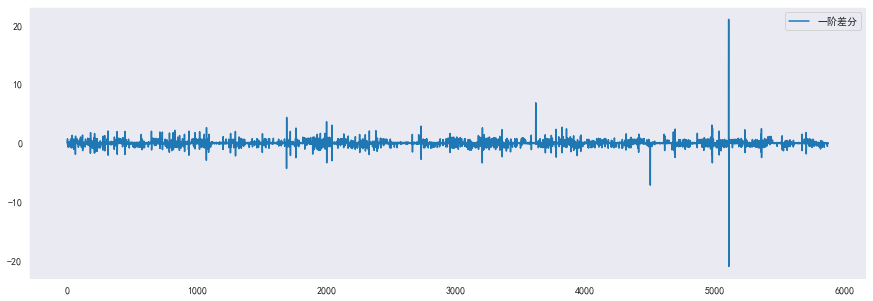

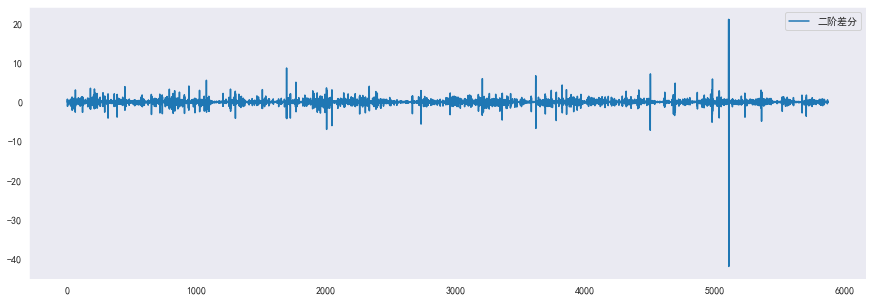

In [51]:
# 差分操作
arx_diff = arx.diff()

print(adfuller(arx_diff[1:]))
plt.figure(figsize=(15, 5))
plt.plot(arx_diff, label='一阶差分')
plt.legend(loc = 'best')
plt.grid()

arx_2diff = arx_diff.diff()
print(adfuller(arx_2diff[2:]))

plt.figure(figsize=(15, 5))
plt.plot(arx_2diff, label='二阶差分')
plt.legend(loc = 'best')
plt.grid()

arx_stable = arx_2diff[2:]

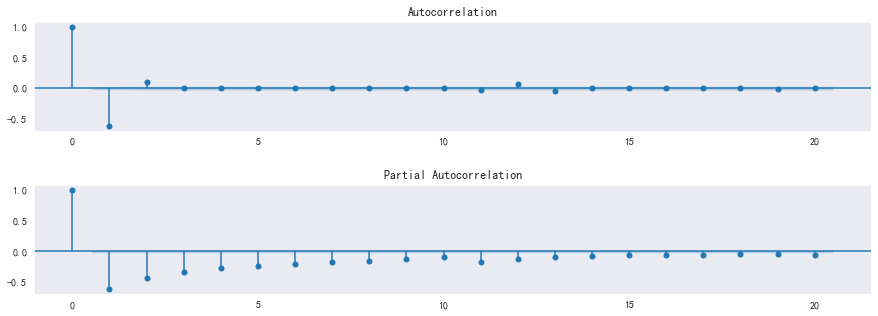

In [52]:
# ACF PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def draw_acf_pacf(ts, lags):
    f = plt.figure(figsize=(15, 5))
    ax1 = f.add_subplot(211)
    plot_acf(ts, ax=ax1, lags=lags)
    plt.grid()
    ax2 = f.add_subplot(212)
    plot_pacf(ts, ax=ax2, lags=lags)
    plt.subplots_adjust(hspace=0.5)
    plt.grid()
    
draw_acf_pacf(arx_stable, 20)

In [55]:
# ARIMA
from statsmodels.tsa.arima.model import ARIMA
arx_stable = np.array(arx_stable)
mod = ARIMA(data_arima, order=(10, 2, 3))
result_arima = mod.fit()
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                     C2   No. Observations:                 5876
Model:                ARIMA(10, 2, 3)   Log Likelihood               -4680.420
Date:                Fri, 04 Jun 2021   AIC                           9388.840
Time:                        10:55:39   BIC                           9482.336
Sample:                             0   HQIC                          9421.343
                               - 5876                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4960      0.266     -5.630      0.000      -2.017      -0.975
ar.L2         -1.4756      0.345     -4.278      0.000      -2.152      -0.800
ar.L3         -0.8488      0.183     -4.633      0.0